In [1]:
# pkg 버전으로 인한 경고메세지 출력시 꼭 필요한 경고 메시지만 출력되도록 하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
# pillow 패키지 없으면 설치
# pip install pillow

### beginz

In [2]:
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2.2.0


In [3]:
# install this pkg if not installed
# pip install tensorflow_datasets

In [4]:
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

# tensorflow_datasets: dataset by tf
# including animals, voice, images, text etc.
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
# local의 데이터셋 로드하기 -> 하려고 했는데 알아서 다운받은거 가져와준다
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    
)

Downloading and preparing dataset cats_vs_dogs/4.0.0 (download: 786.68 MiB, generated: Unknown size, total: 786.68 MiB) to /home/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0...
Dl Completed...: 100%
1/1 [01:45<00:00, 105.32s/ url]
Dl Size...: 100%
786/786 [01:45<00:00, 7.47 MiB/s]

### 이건 무시!
WARNING:absl:1738 images were corrupted and were skipped

Shuffling and writing examples to /home/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteCF4VBS/cats_vs_dogs-train.tfrecord
100%
23261/23262 [00:00<00:00, 59353.65 examples/s]
Dataset cats_vs_dogs downloaded and prepared to /home/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.

In [6]:
# dataset이 잘 다운되었는지 확인하기
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### 모든 데이터셋은 (image, label)의 형태를 가진다 ((None,None,3),())가 이를 나타내는데,
### 앞에있는 (None,None,3)은 image shape를, 뒤의 ()는 정답카테고리인 label의 shape를 의미한다
### 여기서의 임지는 (h, w, channel)로 3차원 데이터이다 -> None, None으로 나타난 이유는 모든 이미지의 크기가 전부 다르기 때문이다
### 3은 색 채널 수이다

## 데이터 다듬기

In [7]:
# 데이터를 확인하기 위한 matplotlib라이브러리 가져오기
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

raw_train 안에 있는 데이터를 확인해 보기 위해 tf.data.Dataset에서 제공하는 take라는 함수를 사용    
이 함수는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수

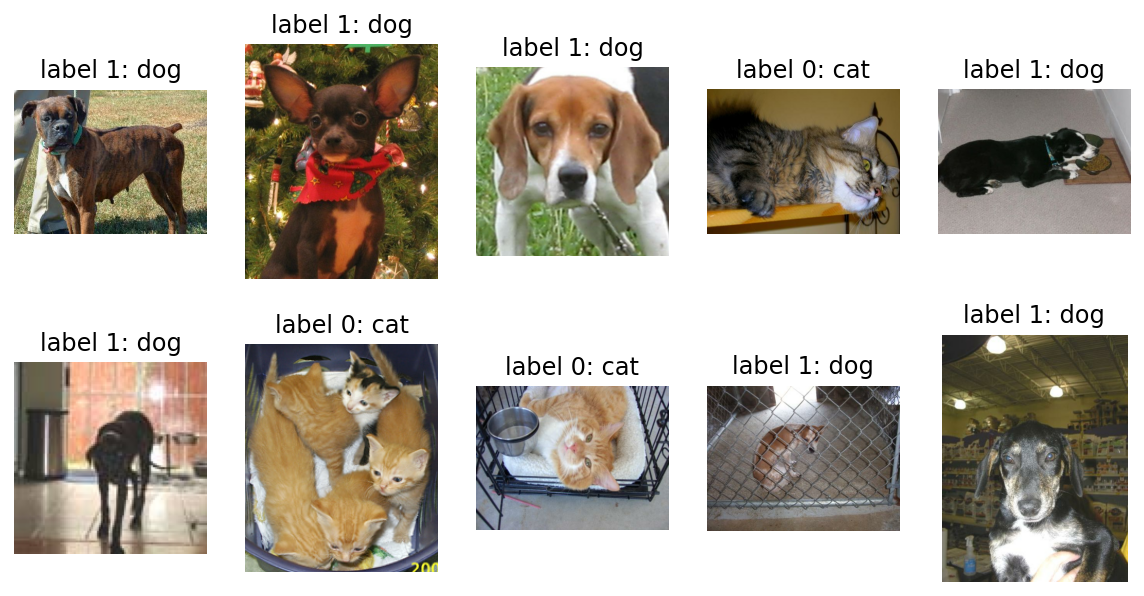

In [8]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# 댕댕쓰는 label 1, otherwise label 0
## 이미지 사이즈가 제각각이므로 사이즈, 포맷을 통일시켜줘야 한다!

In [9]:
# 160x160, pixel scale fix
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [10]:
# format_example 함수를 raw_train, raw_validation, raw_test에 map함수로 적용시켜
# 우리가 원하는 모양의 train, validation, test 데이터셋으로 변환
# for문 없이 map으로 손쉽게 매핑시켜주자!
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

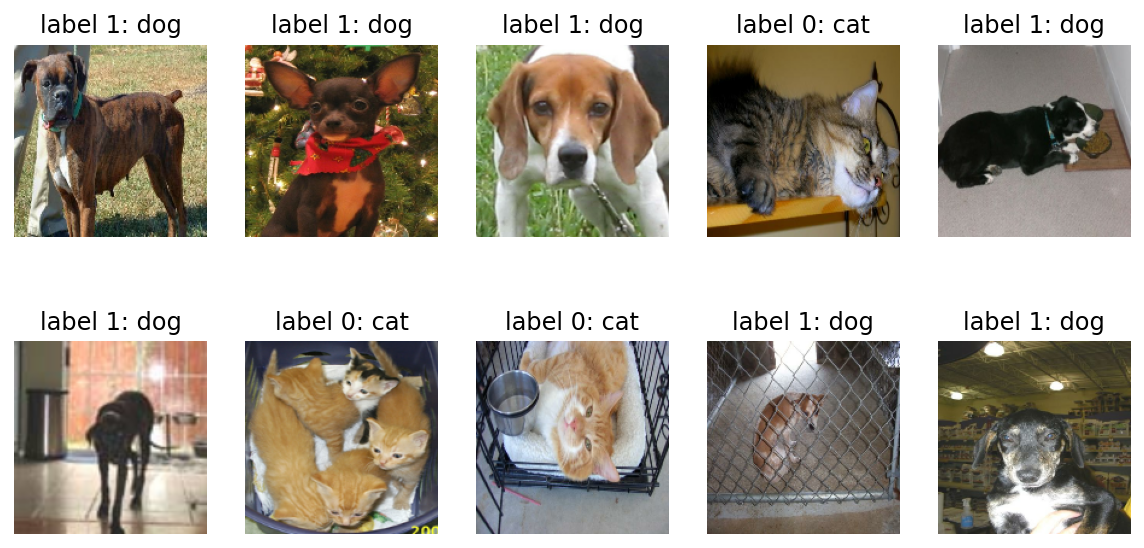

In [11]:
# 다듬은 데이터셋 사진 출력해보기
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 4-5. 데이터 준비 끝 모델 ㄱㄱ

### 텐서플로우 활용한 모델 구조 설계

In [12]:
# models : 모델 자체 구축위한 함수
# layers : 모델의 구성 요소인 여러 레이어, 즉 "층" 이라는 함수들을 갖고있다
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [13]:
# Sequential은 말 그대로 "연속적인" 모델을 쌓기 위한 함수이며
# Sequantial함수 안에 연속적으로 여러 가지 레이어들이 들어간다
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

### 160,160,3에서 conv2d()를 돌리면 3차원 160,160,3 행렬 전체에 16개의 필터를 돌려준 값을 적용하기에 160,160,16으로 바뀐다
### height와 width는 160 → 80 → 40 → 20 으로 점점 작아지고, channel은 16 → 32 → 64까지 커지고 있다.
    
### height와 width는 160 → 80 → 40 → 20 으로 점점 작아지고, channel은 16 → 32 → 64까지 커지고 있다.
### None은 배치(batch, 한 번에 학습시킬 사이즈)
flatten을 거치고 최종적으로 20 * 20 * 64를 건너면 25,600이라는 1차원으로 shape가 줄어들게 된다    
### ===> 이러한 네트워크는 CNN을 사용한 딥러닝 모델의 가장 대표적 형태 (3차원 이미지를 1차원으로 펼치는 것)

### 배열을 다루기 용이한 numpy를 활용하여 이해하기

In [15]:
import numpy as np

image = np.array([[1, 2], [3, 4]])
print(image.shape)
image

# out: [2,2]

(2, 2)


array([[1, 2],
       [3, 4]])

(2,2) 크기를 flatten 시키면?

In [16]:
image.flatten()

# (1,2,3,4) 로 1차원 배열 형태로 지나간다

array([1, 2, 3, 4])

Dense 레이어에서 512개 노드로 축소시킨 후 마지막 최종 출력은 단 두개의 숫자로 구성된 하나의 확률분포가 된다    
=> 각각 입력된 이미지가 댕댕이일 확률 vs고양이일확률

### 결국 딥러닝 모델은 (160, 160, 3) 크기의 3차원 이미지를 입력받아 여러 레이어를 거치며 형태를 바꾸다가 최종적으로는 몇 개의 숫자를 출력해내는 함수라고 할 수 있다

## 4-6. 모델에게 데이터 학습시키기

### 모델 compile 완료 후 학습시키기
모델이 학습하는데 필요한 "학습률"(`learning_rate`) 파라미터를 0.0001로 설정하고 컴파일

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

- compile 하기 위한 세 가지 요소
    1. optimizer : 학습을 어떤 방식으로, 최적화를 어떻게 시킬지 결정 -> 최적화 함수라고도 불림    
    2. loss : 모델이 학습해나가야 하는 방향 결정 | 이 문제는 모델의 출력이 입력맏은 이미지가 고양인지(label=0, [1.0, 0.0]) 강아지인지(label=1, [0.0, 1.0] 에 가깝도록 하는 방향 제시    
    3. metrics : 모델 성능 평가 척도    
                 분류 문제를 풀 때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있다                                                                                 

### 모델 학습시킬 데이터 준비
BATCH_SIZE: 한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE: 셔플 설정

In [18]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

=> 그 후 BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 `train_batches`, `validation_batches`, `test_batches`를 만들어준다
- train_batches: 모델이 끊임없이 학습할 수 있도록 전체 데이터 중 32개를 랜덤으로 뽑아 계속 제공해줄 것

In [19]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [20]:
# train_batches에서 하나의 batch만 꺼내 데이터 확인해보기
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

"""
(TensorShape([32, 160, 160, 3]), TensorShape([32]))
-> image_batch의 shape는 [32,160,160,3]을,label_batch의 shape는 [32]를 나타냄
=> image_batch의 shape는 (160, 160, 3)의 shape인 32개의 데이터가 
존재한다는 뜻이다. 
즉, 데이터 하나의 크기는 (160, 160, 3)이고, 그 개수가 32개이다.
label은 강아지이면 1, 고양이이면 0으로 정답 label을 나타내기 때문에 
한 batch에 데이터가 32개라면 label은 0 또는 1의 32개의 숫자로만 구성된다.

"""

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

### 모델 학습 전 초기모델 성능 validation_batches로 확인해보기
평균 loss와 평균 accuracy 확인

In [21]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

"""
20/20 [==============================] - 1s 70ms/step - loss: 0.6895 - accuracy: 0.5344
initial loss: 0.69
initial accuracy: 0.53
"""

"""
loss: 손실, 얼마나 모델이 틀렸는지를 나타냄
accuracy; 몇 퍼센트 정확도를 보이는지 수치 => 지금 모델은 전혀 의미없음
"""

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-21-dd5a50880f24>:2) ]] [Op:__inference_test_function_1050]

Function call stack:
test_function


### 10 epoch를 학습시켜 정확도 추이 확인해보기 (10~20분 소요)

In [ ]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
Epoch 1/10
582/582 [==============================] - 162s 279ms/step - loss: 0.6007 - accuracy: 0.6688 - val_loss: 0.5370 - val_accuracy: 0.7408
Epoch 2/10
582/582 [==============================] - 164s 283ms/step - loss: 0.4826 - accuracy: 0.7662 - val_loss: 0.5555 - val_accuracy: 0.7266
Epoch 3/10
582/582 [==============================] - 165s 284ms/step - loss: 0.4128 - accuracy: 0.8124 - val_loss: 0.4831 - val_accuracy: 0.7678
Epoch 4/10
582/582 [==============================] - 165s 283ms/step - loss: 0.3596 - accuracy: 0.8419 - val_loss: 0.4655 - val_accuracy: 0.7919
Epoch 5/10
582/582 [==============================] - 171s 293ms/step - loss: 0.3042 - accuracy: 0.8721 - val_loss: 0.5099 - val_accuracy: 0.7799
Epoch 6/10
582/582 [==============================] - 172s 295ms/step - loss: 0.2546 - accuracy: 0.8973 - val_loss: 0.4784 - val_accuracy: 0.7923
Epoch 7/10
582/582 [==============================] - 172s 295ms/step - loss: 0.2029 - accuracy: 0.9225 - val_loss: 0.5066 - val_accuracy: 0.7997
Epoch 8/10
582/582 [==============================] - 171s 293ms/step - loss: 0.1597 - accuracy: 0.9426 - val_loss: 0.5684 - val_accuracy: 0.7919
Epoch 9/10
582/582 [==============================] - 170s 292ms/step - loss: 0.1204 - accuracy: 0.9593 - val_loss: 0.6707 - val_accuracy: 0.7739
Epoch 10/10
582/582 [==============================] - 167s 287ms/step - loss: 0.0851 - accuracy: 0.9732 - val_loss: 0.6242 - val_accuracy: 0.7988

### accuracy: 0.9732 - val_loss: 0.6242 - val_accuracy: 0.7988
    
    
    
## 4-7. 모델 성능 확인해보기
### 모델 학습곡선 확인 및 예측 결과 시각화하기
---
- 첫 번째 accuracy : 훈련 데이터셋에 대한 정확도(학습하고 있는 데이터에 대한 정확도)    
- 두 번째 val_accuracy : 검증 데이터셋에 대한 정확도. 학습하지 않고 있는 데이터에 대한 정확도    

### 학습 단계에 따른 정확도 변화를 그래프로 확인해보기

In [27]:
# 정확도와 손실값 두 가지에 대한 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

training accuracy는 10 epoch를 진행하는 동안 꾸준히 증가한다. 마지막에는 거의 90%를 넘어서는 수치를 보인다.

반면, validation accuracy는 초반에 75%~80% 사이까지는 증가하지만 증가폭이 training dataset에 비해 매우 적고, 증가하는 양상도 불안정하다.

training accuracy는 현재 학습하고 있는 데이터셋에 대한 정확도이기 때문에 모델의 구조나 데이터셋 등에 문제가 없다면 일반적으로 학습하면 할수록 꾸준히 계속 오른다. 반면, validation accuracy는 학습하지 않고 있는 데이터셋에 대한 정확도이기 때문에 일정수준까지 오른 후에는 계속 오를지 장담할 수 없다.

### 오버피팅
- training accuracy는 계속 오르지만 검증 정확도는 어떤 한계선을 넘지 못하고 있다
- loss쪽에서도 training loss 는 안정적으로 감소하지만 validation loss값은 특정 순간 이후로 다시 커진다
    
- 모델의 성능이 제대로 올라가려면 "학습하지 않은" 데이터에 대해서도 성능을 내야만 한다    
- 훈련 데이터만으로 계속 학습하다보니 특정 데이터에만 과도하게 적합(fitting)되어서 일반화 능력이 떨어지는것이다    
=> 즉 딥러닝 모델을 학습시킬 때에는 __이런 과적합 문제를 예민하게 다루고, 과적합이 되지 않는 순간을 캐치하여 일반화가 잘 되는 모델로 학습시키는 것이 중요하다__

### model predict 결과를 확인하고 싶을 땐 model.predict()활용

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

=> array([[9.9969673e-01, 3.0324908e-04],
       [9.5376498e-01, 4.6235040e-02],
       [8.4373772e-02, 9.1562629e-01],
       [9.9915862e-01, 8.4140268e-04],
       [9.8147583e-01, 1.8524185e-02],
       [1.1321680e-01, 8.8678318e-01],
       [1.3622845e-03, 9.9863774e-01],
       [6.0681301e-01, 3.9318699e-01],
       [2.2142710e-02, 9.7785723e-01],
       [5.4410223e-02, 9.4558978e-01],
       [5.5628005e-02, 9.4437200e-01],
       [9.9999058e-01, 9.4200523e-06],
       [9.9918729e-01, 8.1266626e-04],
       [2.0574625e-03, 9.9794251e-01],
       [9.8906797e-01, 1.0932011e-02],
       [9.9953711e-01, 4.6294770e-04],
       [9.9048072e-01, 9.5192706e-03],
       [1.5232921e-07, 9.9999988e-01],
       [9.2932576e-01, 7.0674263e-02],
       [9.9805295e-01, 1.9470638e-03],
       [9.9559337e-01, 4.4066142e-03],
       [5.0808764e-01, 4.9191239e-01],
       [9.9977976e-01, 2.2022260e-04],
       [9.8769963e-01, 1.2300398e-02],
       [8.8159782e-01, 1.1840217e-01],
       [1.7346926e-02, 9.8265314e-01],
       [9.9980408e-01, 1.9599794e-04],
       [2.1539322e-01, 7.8460681e-01],
       [9.9291539e-01, 7.0845978e-03],
       [9.8577487e-01, 1.4225107e-02],
       [9.9938929e-01, 6.1073754e-04],
       [1.4564213e-01, 8.5435784e-01]], dtype=float32)
       
### => 수많은 소수점 값들로 이루어진 predictions: [모델이 판단한 묘일확률, 댕일확률] 이며, [1.0, 0.0]에 가까울수록 label이 0인 고양으로, [0.0, 1.0]에 가까울수록 [0.0, 1.0]에 가까울수록 label이 1인 댕댕이로 예측함    
즉, 오른 쪽이 높으면 댕댕이, 아니면 고양이로 예측함

In [ ]:
# prediction값들을 실제 추론한 라벨(고0, 강1)으로 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

"""
array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1])
"""

In [ ]:
# 32장의 이미지와 32개의 라벨, 그리고 32개의 prediction으로 각각을 모두 시각화하여 확인하기
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
# 위의 코드를 이용하여 직접 맞은 예측의 개수를 세는 코드 짜보기
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct: count+=1

print(count / 32 * 100)    # 약 70% 내외

나보다 똑똑하고 돈 많은 누군가가 이미 만들어놓은 모델을 활용하자    
- 나의 현재 스코어: 검증 정확도 80%
- 남은 과연..?

## 4-8. 가져다 쓰는 분류기 (1) 바퀴를 재발명하지 말라

### 이미지 분류 대회인 ILSVRC, ImageNet이 무엇인지 알아보고, Transfer Learning의 개념 알아보기
    
- ILSVRC는 ImageNet Large Scale Visual Recognition Challenge의 약자로, 이미지를 분류하는 대회이다. 
- 2017년 이후 대회에서 활약하는 모델들의 성능이 사실상 사람을 뛰어 넘었다고 판단되었기 때문에 종료되었다. ('17년 마지막 해 우승 모델인 SeNet은 2.3%의 아주 낮은 오차율을 보임)
- 대회에서 사용되는 데이터셋은 ImageNet이라는 데이터셋으로, 총 1000개의 카테고리와 수백 만의 이미지 데이터로 이루어져 있다.
    => ILSVRC대회에서 사용된 모델 활용하여 강고 분류기 활용하기

### Transfer Learning - 거인의 어깨에 서서 


__전이학습에 이용되는 몇몇의 사전 학습 모델들의 구조__    
- 큰 사이즈의 합성곱 신경망 (Convolutional Neural Networks, CNN) 구조 (Voulodimos et al. 2018). 
- 일반적으로, CNN은 다양한 컴퓨터 비전 문제에서 뛰어난 성능을 보여주는 것으로 나타났습니다 (Bengio 2009). CNN이 받은 최근 몇 년 간의 뜨거운 관심은 좋은 성능과, 동시에 학습을 쉽게 할 수 있다는 두 가지 메인 요소가 있었기 때문입니다.


__CNN모델의 두 파트와 하는 일__    
- 합성곱층과 풀링층이 여러겹 쌓여있는 Convolutional base : 이미지로부터 특징을 효과적으로 추출하는 것 (feature extraction)
- 완전 연결 계층으로 이루어진 Classifier : 추출된 특징을 잘 학습해서 이미지를 알맞은 카테고리로 분류하는 것 (image classification)


__Convolutional base의 낮은 계층과 높은 계층의 의미와 하는 일__    
- 낮은 레벨의 계층은 input에 가까운 계층으로, 이미지에서 주로 일반적인(general) 특징을 추출한다.

- 높은 레벨의 계층은 output에 가까운 계층으로, 보다 구체적이고 특유한 특징을 추출한다.
    
    
__전이학습의 세 가지 전략__    
- 전략 1은 전체 모델을 새로 학습시키는 것이다. 이 경우에는 사전학슴 모델의 구조만 사용한다. 모델을 완전히 새로 학습시켜야하므로, 큰 사이즈의 데이터셋과 좋은 컴퓨팅 연산 능력이 있을 때 적합하다.

- 전략 2는 Convolutional base의 일부분은 고정시킨 상태로, 나머지 계층과 classifier만 새로 학습시키는 것이다. 데이터셋의 크기에 따라 얼마나 많은 계층을 새로 학습시킬지 달라지는데, 데이터의 양이 많을수록 더 많이 새로 학습시키고, 데이터의 양이 적을수록 학습시키는 부분을 적게 한다.

- 전략 3은 Convolutional base는 고정시키고, classifier만 새로 학습시키는 것이다. 이 경우는 convolutional base는 건들지 않고 그대로 두면서 특징 추출 매커니즘으로 활용하고, classifier만 재학습시키는 방법이다. 컴퓨팅 연산능력이 부족하거나 데이터셋이 작을 때 고려해볼 수 있다.
    
    
- 데이터셋의 크기를 고려한 전이학습 전략은?
ILSVRC에서 쓰인 모델로, 해당 대회는 수백 만 장의 데이터로 학습된 모델이다. 그에 비해 우리가 새로 학습시킬 데이터는 강아지와 고양이는 약 2만 장으로, 비교적 매우 작은 데이터셋이다. 따라서 모델을 새로 학습시키기보다는, 가져오는 모델은 이미지에서 특징을 추출하는 매커니즘으로 활용하고, classifier만 새로 학습시키는 전략 3이 적절하다.

### Transfer Learning은 누군가 이미 잘 만들어놓은 모델을 가져와서, 내 입맛에 맞게 일부분만 새로 학습시켜 사용하는 것이라고 할 수 있다
    
    여러 방법이 있지만 그 중 "classifier" 부분만 새로 학습시키는, 즉 적은 부분만 새로 학습시키는 전략을 활용할 것
    
convolutional base는 모두 freeze시키고, 아래의 classifier 부분만 새로 학습시키는것

## 4-9. 가져다 쓰는 분류기 (2) 아주 똑똑한 모델을 간단히 가져오는 방법

### 사전 학습 모델인 VGG16을 가져오고 구조 확인하기
- '14년 ILSVRC 물체 위치 찾기(localization) 태스트 우승 모델인 VGG모델 사용하기
- 2014년 이후 뛰어난 성능을 보이는 다양한 새로운 모델이 개발되었지만, VGG는 단순한 구조임에도 꽤나 괜찮은 성능을 보여서 아직까지 많은 이미지 처리 분야에서 사랑받는 모델 중 하나

__간단한 코드로 vgg 모델을 `base_model`의 변수로 불러오기__    
위에 언급한 대로, VGG모델을 가져올 때 output에 가까운 높은 레벨에 있는    
3개의 FC레이어는 제외하고 불러와야 하므로    
`include_top=False`옵션을 주어야한다!!    
[텐서플로우 케라스에서 제공하는 VGG16 튜토리얼](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)

In [28]:
# 잘 학습된 모델 가져오기
# 이미지 인풋을 받아 해당 이미지의 특징을 잘 뽑아낸 특징 벡터를 추출해낼 수 있다
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')


In [29]:
# 실제 모델에 이미지 데이터 넣어보기
# 학습때 사용했던 image_batch를 넣어보기

# 넣기 전에 image_batch의 원 사이즈 확인
image_batch.shape

# 32 : 이미지의 장수, 각 이미지 크기 160,160,3

# 모델에 배치를 넣은 결과 shape
feature_batch = base_model(image_batch)
feature_batch.shape
# TensorShape([32, 5, 5, 512])

# 모델 구조 확인
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [ ]:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 40, 40, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 40, 40, 256)       590080    
_________________________________________________________________
block3_conv3 (Conv2D)        (None, 40, 40, 256)       590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 20, 20, 256)       0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 20, 20, 512)       1180160   
_________________________________________________________________
block4_conv2 (Conv2D)        (None, 20, 20, 512)       2359808   
_________________________________________________________________
block4_conv3 (Conv2D)        (None, 20, 20, 512)       2359808   
_________________________________________________________________
block4_pool (MaxPooling2D)   (None, 10, 10, 512)       0         
_________________________________________________________________
block5_conv1 (Conv2D)        (None, 10, 10, 512)       2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        (None, 10, 10, 512)       2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        (None, 10, 10, 512)       2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   (None, 5, 5, 512)         0         
=================================================================
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________

-> 행이 많다 == 레이어의 개수가 많다

- [모델 구조 확인하기](https://neurohive.io/en/popular-networks/vgg16/)
- VGG16 모델에 쓰인 네 종류의 레이어 : Conv(Convolutional layer), Pooling(MaxPooling layer), Dense(Fully connected layer), softmax layer
    
- VGG16 모델 => 5개의 Conv-pooling block, 1개의 Dense블록
- 첫 번째 블록 : 2개의 Conv 레이어와 1개의 Pooling 레이어
- 두 번째 블록 : 2개의 Conv 레이어와 1개의 Pooling 레이어
- 세 번째 블록 : 3개의 Conv 레이어와 1개의 Pooling 레이어
- 네 번째 블록 : 3개의 Conv 레이어와 1개의 Pooling 레이어
- 다섯 번째 블록 : 3개의 Conv 레이어와 1개의 Pooling 레이어
- 여섯 번째 블록 : 3개의 Dense 레이어
    
- 마지막의 Dense 레이어로 이루어진 블록이 빠졌다. 이 블록은 우리가 Transfer Learning을 수행하며 새로 학습시킬 것이기 때문에 빠진 부분이다.

## 4-10. 가져다 쓰는 분류기 (3) 모델의 마지막 부분만 내 입맛대로 재구성하기
    
### VGG16 끝단에 classifier 레이어 붙여서 원하는 구조의 모델 만들기
---
-  VGG16 모델을 가져와서 모델이 이미지로부터 특징을 추출하는 벡터를 내뱉는다는 것을 확인했다
- 이제 모델이 추출한 특징벡터로부터 분류를 할 수 있는 classifer를 우리가 구성해야 한다


In [30]:
feature_batch.shape
# TensorShape([32, 5, 5, 512])
# 그런데, classifier를 구성하려면 우리는 Fully connected(완전연결) 레이어로 구성해야 하므로
# 말 그대로 이전 계층의 모든 숫자들이 다음 계층의 모든 숫자와 연결이 되어야 하는데
# 이러한 구조로 인해 Fully connected 레이어에 입력될 수 있는 벡터는 반드시 1차원이어야 한다

TensorShape([32, 5, 5, 512])

In [31]:
# ==> 3차원 벡터를 1차원 벡터로 : flatten layer!
import numpy as np

image = np.array([[1, 2],
                  [3, 4]])

flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print()
print("Flattened image:\n", flattened_image)
print("Flattened image shape:", flattened_image.shape)
# 2차원의 이미지를 flatten하면 위와 같이 1차원의 이미지로 쭉 펼 수 있

Original image:
 [[1 2]
 [3 4]]
Original image shape: (2, 2)

Flattened image:
 [1 2 3 4]
Flattened image shape: (4,)


### 2차원 또는 3차원 벡터를 1차원으로 축소시키는 방법에는 Flattening 하는 것보다 조금 더 좋은 방법 : [Global Average Pooling](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/2d-global-average-pooling)
- Global Average Pooling을 거치게 되면 (Height, Width, Depth)의 shape를 가지는 3차원 이미지의 shape가 (1,1,Depth)로 바뀌게 된다. 이는 그냥 (Depth)의 shape로, 1차원 벡터로 볼 수 있다 (32, 512랑 같다)

In [1]:
# Global Average Pooling 계층을 만드는 코드
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# global_average_layer에 위에서 VGG16이 출력했던 feature_batch를 입력
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

NameError: name 'tf' is not defined

In [33]:
# 마지막으로 Dense 레이어들을 붙여주면 custumized classifier가 완성됨
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

# out : 32, 512   =>   32, 2
"""
우리의 데이터들은 처음에 이미지에서 특징을 추출해 줄 VGG16, 
base_model에 입력되어 특징이 추출된 다음, 
그 특징벡터는 global_average_layer를 거쳐 마지막에 
prediction_layer까지 통과하며 강아지인지, 고양이인지 
예측이 될 것입니다.
"""

(32, 2)


'\n우리의 데이터들은 처음에 이미지에서 특징을 추출해 줄 VGG16, \nbase_model에 입력되어 특징이 추출된 다음, \n그 특징벡터는 global_average_layer를 거쳐 마지막에 \nprediction_layer까지 통과하며 강아지인지, 고양이인지 \n예측이 될 것입니다.\n'

In [34]:
# vgg16 에 해당하는 base_model은 학습을 시키지 않을 예정이니 
# 학습 여부를 결정하는 trainable변수를 False로 지정해 "꺼주겠"다
base_model.trainable = False

# 진짜 최종 모델 만들기
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

# 최종 모델 구조 확인하기
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
=================================================================
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________

SyntaxError: invalid syntax (<ipython-input-35-d91bb3bf0121>, line 3)

VGG16 안에는 위에서 봤던 복잡한 레이어들이 들어있지만, base_model로 추상화시키면서 간결하게 표시돠는것

## 4-11. 가져다 쓰는 분류기 (4) 거인의 어깨에 올라타서 예측하니 더 잘 된다

### VGG16을 기반으로 구성된 이미지 분류기를 학습시키고, 직접 만들었던 모델과 결과 비교해 보기

In [ ]:
# 위에서 했던 과정과 동일하게 optimizer, loss, metrics를 준비해서 
# 모델을 compile하면 끝
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 위 과정과 동일하게 초기 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 3/20 [===>..........................] - ETA: 19s - loss: 0.7386 - accuracy: 0.4583

In [ ]:
# 모델 학습 시작
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
# 그래프로 학습 과정 추이도 확인하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 32개의 test sample에 대한 예측 결과를 눈으로도 확인
# 샘플을 test_batches에서 가져와서 예측 결과 만들기

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

# 역시 0과 1 사이의 값으로 확률값을 출력함
# 이번에도 prediction 값들을 실제 추론한 라벨(고양이:0, 강아지:1)로 변

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')
# out : 32개 모두 정답

In [ ]:
# 10개에 대한 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 10 * 100) 

## 4-12. 가져다 쓰는 분류기 (5) 잘 학습된 모델은 저장해두고 언제든 꺼내 쓰도록 하기

### 모델을 save하고, 다시 load해와서 사용하는 방법 익히기
---
기껏 학습시켰으니 일회성이 아닌 저장해두고 언제든 불러와 쓰도록 한다
- 저장하는 방법: `save_weights` 함수를 활용하여 파라미터로 저장하고 싶은 경로만 입력하면 된다
-> ./checkpoint/checkpoint 라는 경로로 저장할 시 현재 위치에 있는 checkpoint라는 폴더에 checkpoint라는 파일명으로 저장된다    
```
$ mkdir -p ~/aiffel/cat_vs_dog
$ mkdir -p ~/aiffel/cat_vs_dog/checkpoint
$ mkdir -p ~/aiffel/cat_vs_dog/images
```
혹은 원하는 경로에 반드시 checkpoint, images 폴더를 만들어줘야 안전하다!!

In [ ]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/e/E04_dogcat_classifier/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

## 4-13. 가져다 쓰는 분류기 (6) 나는 무슨 상일까?
### 학습된 모델에 원하는 이미지를 입력해 예측 결과 확인하기
---
__강아지 말고 내가 원하는 이미지를 넣어서 예측 시켜보기__
-> 원하는 이미지를 이전스텝에서 만든 경로의 images폴더에 저장시키기

In [1]:
img_dir_path = os.getenv("HOME") + "/aiffel/e/E04_dogcat_classifier/images"
os.path.exists(img_dir_path)

NameError: name 'os' is not defined

## 꿀팁) 디렉토리 여는 커맨드
`xdg-open ~/aiffel/e/E04_dogcat_classifier/images`    
=> 여기에 이미지를 넣자

In [ ]:
# 이미지 파일 저장 후 tf 모델에 입력해주기 위해 load_img, img_to_array함수를 가져오기
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 이미지 가져오기
# 단, 지금 모델은 160,160 사이즈만 입력받으므로 param으로 이미지사이즈를 넣어줘야한다
IMG_SIZE = 160
IMG_NAME = 'dog1.jpg'
dog_image_path = os.path.join(img_dir_path, IMG_NAME)

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

# ## img 가져오고 사이즈도 맞췄다면 모델에 넣을 수 있도록 이미지를 array, 즉 배열 형태로 변환하기
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape
# (1, 160, 160, 3) 로 앞서 사용한 이미지데이터 shape와 비슷하다

# 예측하기
prediction = model.predict(dog_image)
prediction


# array([[0., 1.]], dtype=float32) 강아지일 확률 100

=> 함수로 만들기 (filename만 바꾼 후 원하는대로 실험)

In [ ]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

In [ ]:
# 함수 실행
filename = 'd1.jpeg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
# This image seems 100.0% dog, and 0.0% cat.

# 4-14. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기
자, 이제 여러분의 차례입니다.    
지금까지 진행했던 모든 과정을 통째로 활용해서, 새로운 데이터셋에 대해 여러분의 직접 모델을 만들어 볼 것입니다.    
    
다음에 제안된 순서는 모두 위에서 진행했던 과정의 일부입니다. 몇 가지 코드만 수정하면 성공적으로 프로젝트를 진행할 수 있을 것입니다.    
진행하다가 혹시 도움이 필요하다면 위에서 진행했던 실습 코드를 다시 참고하세요! 모든 해답은 그 안에 있습니다.    
    
그러면, 시작해볼까요!    
    
## Step 1. 데이터셋 내려받기
이번에는 `tensorflow_datasets` 에 포함된 `tf_flowers` 데이터를 사용해 보겠습니다. `tf_flowers` 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.    
`tfds.load`를 활용하여 데이터셋을 다운받으세요.    
https://www.tensorflow.org/datasets/catalog/tf_flowers
    
## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
이미지를 모두 같은 크기로 formatting 한 후, `train_batches`, `validation_batches`, `test_batches`를 준비합니다.
## Step 3. 모델 설계하기
모델은 어떤 방식으로 설계하고 싶은가요? 나만의 모델을 만들 것인가요, 아니면 `base_model`을 활용할 것인가요?    
원하는 방식으로 모델을 만들어 보세요!    
`cats_vs_dogs` 의 경우와 달리, `tf_flowers` 데이터셋에서는 class의 갯수가 5가지입니다. 모델 설계시 어느 부분이 달라질지에 유의해 주세요.    
## Step 4. 모델 학습시키기    
모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.    
예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, `learning_rate` 값을 바꿔볼 수 있습니다.    
또는, `optimizer`의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, [여기](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)를 참고하세요.    
어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.    
이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.    
## Step 5. 모델 성능 평가하기
모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.
모델이 학습된 과정을 그래프로도 그려보고, `validation_batches`나 `test_batches`에 있는 데이터에 대한 예측 결과도 확인해 보세요!
## Step 6. 모델 활용하기
모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.
원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!

### 딥러닝의 `레이어` 개념
### 딥러닝 모델은 언제나 위처럼 여러 개의 층을 쌓은 형태로 구성된다
### Conv2D, MaxPooling2D, Flatten, Dense 네 종류의 레이어를 사용한 것!

In [1]:
# 실제 모델에 이미지 데이터 넣어보기
feature_batch = base_model(image_batch)
feature_batch.shape


# global average pooling(dense대체)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# global_average_layer에 위에서 VGG16이 출력했던 feature_batch를 입력
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


# 마지막으로 Dense 레이어들을 붙여주면 custumized classifier가 완성됨
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

# vgg16 에 해당하는 base_model은 학습을 시키지 않을 예정이니 
# 학습 여부를 결정하는 trainable변수를 False로 설정한다
base_model.trainable = False

NameError: name 'feature_batch' is not defined

In [ ]:
# 최종 모델 만들기
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

# 최종 모델 구조 확인하기
model.summary()


# 모델을 compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 위 과정과 동일하게 초기 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
# 모델 학습시키기
import time
start=time.time()

# 모델 학습 시작
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

print('MobileNet 걸린 시간:',time.time()-start)

In [ ]:
# 그래프로 학습 과정 추이도 확인하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 위 과정과 동일하게 초기 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [2]:
# 성능 평가하기
# 역시 0과 4 사이의 값으로 확률값을 출력함
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions


# 을 0~n 개 사이의 값으로 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions


# 배치 개 만큼 출력해서 맞/틀 보기
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')
    
    
# 10개에 대한 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 10 * 100)

In [ ]:
# 실제 이미지 가져와서 예측하기
img_dir_path = os.getenv("HOME") + "/aiffel/e/E04_dogcat_classifier/images"
os.path.exists(img_dir_path)

In [ ]:
# 0: dandelion  1: daisy   2: tulips   
# 3: sunflowers   4: roses

# write it just once!

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandel_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandel_percentage}% dandelion, and {daisy_percentage}% daisy.")
    print(f"And it's {tulips_percentage}% tulips, {sunflowers_percentage}% sunflowers and finally {roses_percentage}% roses.")

In [ ]:
# 이미지 실행
# 함수 실행
filename = 'dandel.jpg'
show_and_predict_image(img_dir_path, filename)

filename = 't1.jpeg'
show_and_predict_image(img_dir_path, filename)

filename = 'daisy3.jpg'
show_and_predict_image(img_dir_path, filename)

filename = 'sunf2.jpeg'
show_and_predict_image(img_dir_path, filename)

filename = 'roses2.jpg'
show_and_predict_image(img_dir_path, filename)